# Loading libraries

In [1]:
import numpy as np
from scipy.stats import ortho_group
import torch
device = 'cpu'
import time
import matplotlib.pyplot as plt
from itertools import cycle
lines = ["-","--","-.",":"]
linecycler = cycle(lines)

# Numerical schemes for simulating the linearized solver

In [2]:
def update(values, q, terms):
    """update function for simulating the linearized approaching to solve the ODE.
        
        Parameters
        ----------
        values : torch.Tensor
            The y_hat vector in a simplified form. 0th dimension for order from 0 to N. 1st dimension for different parameters.
        q: int
            Order of the ODE.
        terms: List
            List of matrices for different order dynamics.
            Each matrix is the F matrix.
            The first dimension is the change in the parameters.
            The second dimension is the polynomials.
        """
    total_orders, parameters = values.shape
    # Buffer storing the delta y_hat, the change to values.
    addition = torch.zeros_like(values).to(device)
    # Calculate changes to y_hat due to the order-th order dynamics
    for order in range(0, q + 1):
        if order != 0:
            beginning_order_values = torch.concat([values[order-1:], torch.zeros([order-1, parameters]).to(device)])
        # Sources of change. Eventually order_values should have the values of all the polynomial terms
        order_values = torch.ones([total_orders, 1], dtype=torch.double)
        order_values[total_orders - order:] = 0
        for _ in range(order):
            # Batch parallel outer products
            order_values = torch.einsum('ab,ac->abc', order_values, beginning_order_values).reshape(total_orders, -1)
        # Multiplying the polynomial coefficiets by the F matrix for change contribution
        add = torch.tensordot(order_values, terms[order], dims=([1], [1]))
        addition += add
    values += addition

def ideal_update(values, q, terms):
    addition = torch.zeros_like(values).to(device)
    for order in range(0, q + 1):
        beginning_order_values = values
        order_values = torch.ones(1, dtype=torch.double)
        for _ in range(order):
            order_values = torch.einsum('b,c->bc', order_values, beginning_order_values).reshape(-1)
        add = torch.tensordot(order_values, terms[order], dims=([0], [1]))
        addition += add
    values += addition

# Defining the ODE

In [3]:
# Total number of parameters
n_params = 100
# Fraction of positive eigenvalues
positive_fraction = 1
# Generate random eigenvalues
positive_eigenvalues = np.random.rand(int(n_params*positive_fraction))
negative_eigenalues = - np.random.rand(n_params - int(n_params*positive_fraction)) * 0.01
eigenvalues = np.diag(np.concatenate([positive_eigenvalues, negative_eigenalues]))
# Random orthogonal matrix that performs the change of basis to change F1 from diagonal to non-diagonal
orthogonal_matrix = ortho_group.rvs(dim=n_params)
learning_rate = 0.3
# Order of ODE
q = 2
# Strength of second order contributions
# Since there are n_params times more second order terms than first order terms, each entry should be n_params times smaller for equal strength
# Here the strength is 3 percent of first order
F2_factor = 0.0003
F2 = - learning_rate * F2_factor * (np.random.rand(n_params, n_params**2) - 0.5)
F1 = - learning_rate * orthogonal_matrix.dot(eigenvalues).dot(np.linalg.inv(orthogonal_matrix))
F0 = learning_rate * np.random.rand(n_params, 1) * 0
F2 = torch.tensor(F2)
F1 = torch.tensor(F1)
F0 = torch.tensor(F0)
terms = [F0, F1, F2]

# Simulating the effect of increasing QDM order on error with all positive Hessian eigenvalues

In [4]:
epochs = 3000
total_orders = 10

approx_trajectory = [[] for _ in range(q, total_orders + 1, q)]
ideal_trajectory = []
values_start = np.random.rand(1, n_params)
values = torch.tensor(np.copy(values_start).reshape(-1))
ideal_trajectory.append(np.copy(values.cpu().detach().numpy()))

'''Ideal evolution of the difference equation'''
for epoch in range(epochs):
    ideal_update(values, q, terms)
    ideal_trajectory.append(np.copy(values.cpu().detach().numpy()))

'''Simulate evolution using the linearized solver'''
for i, orders in enumerate(range(q, total_orders + 1, q)):
    start = time.time()
    values = np.repeat(np.copy(values_start), orders + 1, axis=0)
    values = torch.tensor(values).to(device)
    approx_trajectory[i] = [np.copy(values[0].cpu().detach().numpy())]

    for epoch in range(epochs):
        update(values, q, terms)
        approx_trajectory[i].append(np.copy(values[0].cpu().detach().numpy()))
            
    print('Time taken for order {}: {} seconds.'.format(orders, time.time() - start))

Time taken for order 2: 4.185311555862427 seconds.
Time taken for order 4: 4.206953048706055 seconds.
Time taken for order 6: 4.287428855895996 seconds.
Time taken for order 8: 5.555868148803711 seconds.
Time taken for order 10: 4.813897371292114 seconds.


### Plotting results

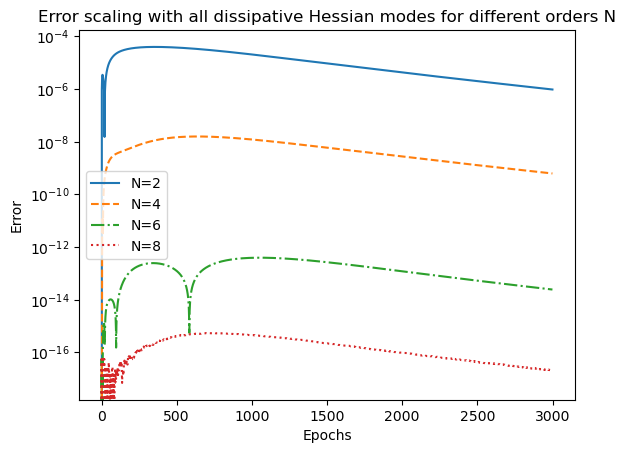

In [6]:
length = -1
parameter = 0
x_start = 10
min_error = 1000
for i, orders in enumerate(range(q, total_orders, q)):
    error = np.abs(np.array(approx_trajectory[i])[: length, parameter] - np.array(ideal_trajectory)[: length, parameter])
    min_error = min(min_error, np.min(error[x_start]))
    plt.plot(error, next(linecycler), label='N={}'.format(orders))
plt.legend()
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Error scaling with all dissipative Hessian modes for different orders N')
plt.show()

# Simulating the effect of changing the fraction of positive Hessian eigenvalues

In [8]:
length = -1
parameter = 0
x_start = 5
n_params = 100
min_error = 1000
fractions = [1, 0.99, 0.9, 0.5, 0.1]
ideal_trajectory = [[] for positive_fraction in fractions]
approx_trajectory = [[] for positive_fraction in fractions]

for i, positive_fraction in enumerate(fractions):
    positive_eigenvalues = np.random.rand(int(n_params*positive_fraction))
    negative_eigenalues = - np.random.rand(n_params - int(n_params*positive_fraction)) * 0.01
    eigenvalues = np.diag(np.concatenate([positive_eigenvalues, negative_eigenalues]))
    orthogonal_matrix = ortho_group.rvs(dim=n_params)
    learning_rate = 0.3
    q = 2
    F2_factor = 0.0003
    F2 = - learning_rate * F2_factor * (np.random.rand(n_params, n_params**2) - 0.5)
    F1 = - learning_rate * orthogonal_matrix.dot(eigenvalues).dot(np.linalg.inv(orthogonal_matrix))
    print((np.linalg.eigvals(F1)>0).sum())
    F0 = learning_rate * np.random.rand(n_params, 1) * 0
    F2 = torch.tensor(F2)
    F1 = torch.tensor(F1)
    F0 = torch.tensor(F0)
    terms = [F0, F1, F2]

    epochs = 3000

    values_start = np.random.rand(1, n_params)
    values = torch.tensor(np.copy(values_start).reshape(-1))
    ideal_trajectory[i] = [np.copy(values.cpu().detach().numpy())]
    for epoch in range(epochs):
        ideal_update(values, q, terms)
        ideal_trajectory[i].append(np.copy(values.cpu().detach().numpy()))
    orders = 4
    start = time.time()
    values = np.repeat(np.copy(values_start), orders + 1, axis=0)
    values = torch.tensor(values).to(device)
    approx_trajectory[i] = [np.copy(values[0].cpu().detach().numpy())]

    for epoch in range(epochs):
        update(values, q, terms)
        approx_trajectory[i].append(np.copy(values[0].cpu().detach().numpy()))
            
    print('Time taken for order {}: {} seconds.'.format(orders, time.time() - start))

0
Time taken for order 4: 5.285477638244629 seconds.
1
Time taken for order 4: 3.8843624591827393 seconds.
10
Time taken for order 4: 5.861119747161865 seconds.
50
Time taken for order 4: 4.484201669692993 seconds.
90
Time taken for order 4: 4.405484199523926 seconds.


### Plotting results

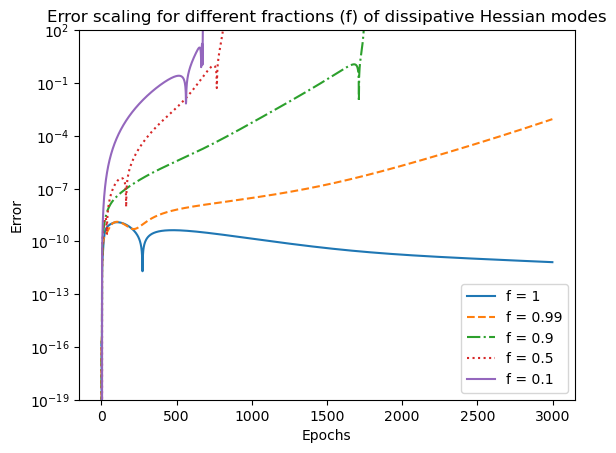

In [9]:
min_error = 1000
length = 3000
for i, positive_fraction in enumerate(fractions):
    error = np.abs(np.array(approx_trajectory[i])[: length, parameter] - np.array(ideal_trajectory[i])[: length, parameter])
    min_error = min(min_error, np.min(error[x_start]))
    plt.plot(error, next(linecycler), label='f = {}'.format(positive_fraction))
    
plt.legend()
plt.yscale('log')
plt.ylim(max(min_error*0, 10**(-19)), 10**(2))
plt.title('Error scaling for different fractions (f) of dissipative Hessian modes')
plt.xlabel('Epochs')
plt.ylabel('Error')
# plt.savefig('Error vs epoch with different hessians lr_0.3 order_2 f2_0.0003 ng_0.01.svg')
plt.show()